In [77]:
# Standard library imports
import os
import sys
import re
import warnings
import random
import hashlib

# Data manipulation and analysis
import numpy as np
import pandas as pd

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Machine learning and preprocessing
from sklearn.metrics import confusion_matrix, classification_report, precision_score
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler  # Assuming you might need it

# Specific models and tools
from xgboost import XGBClassifier
import xgboost as xgb

# Encoding and feature selection
from category_encoders import TargetEncoder  # Fixed the import based on usage
from scipy.stats import randint, uniform

# Model persistence
from joblib import dump, load

# Miscellaneous settings
%matplotlib inline
warnings.filterwarnings('ignore')


In [78]:
competitions = [

    # Code, Seasons
    ['E0', [2324, 2223, 2122, 2021, 1920]],
    ['D1', [2324, 2223, 2122, 2021, 1920]],

]

In [79]:
matches_files = []

In [80]:
for comp in competitions:

    for season in comp[1]:

        matches_files.append(f"data/matches/{comp[0]}_{season}.csv")

In [81]:
# Load and concatenate matches data into a single DataFrame
df = pd.DataFrame()

for file in matches_files:

    try:
        df_temp = pd.read_csv(file)
        df = pd.concat([df, df_temp], ignore_index=True)
    except:
        # print an error message
        print(f'Error: {file} not found')

# print the amount of data loaded
print(f"Data loaded: {df.shape[0]} matches")

Data loaded: 3261 matches


In [82]:
df.head()

,Div,Date,Time,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,...,BbMx>2.5,BbAv>2.5,BbMx<2.5,BbAv<2.5,BbAH,BbAHh,BbMxAHH,BbAvAHH,BbMxAHA,BbAvAHA
0,E0,11/08/2023,20:00,Burnley,Man City,0,3,A,0,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,E0,12/08/2023,12:30,Arsenal,Nott'm Forest,2,1,H,2,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,E0,12/08/2023,15:00,Bournemouth,West Ham,1,1,D,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,E0,12/08/2023,15:00,Brighton,Luton,4,1,H,1,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,E0,12/08/2023,15:00,Everton,Fulham,0,1,A,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [83]:
# Convert 'Div' to a categorical type, a numeric representation of the division
df['Div'] = df['Div'].astype('category').cat.codes

In [84]:
# Create a unique list of HomeTeam and AwayTeam names combined, and add an index to each team
teams = pd.concat([df['HomeTeam'], df['AwayTeam']]).unique()

# Sort the teams alphabetically
teams.sort()

# Convert to an array of dictionaries
teams = [{'team': team, 'index': index} for index, team in enumerate(teams)]

In [85]:
# Create a unique list of Referees, and add an index to each Referee
referees = pd.concat([df['HomeTeam'], df['AwayTeam']]).unique()

# Sort the teams alphabetically
referees.sort()

# Convert to an array of dictionaries
referees = [{'referee': referee, 'index': index} for index, referee in enumerate(referees)]

In [86]:
# Map the FTR column to a binary outcome
df['FTR'] = df['FTR'].map({'H': 1, 'D': 0, 'A': 0}).astype(int)
df['HTR'] = df['HTR'].map({'H': 1, 'D': 0, 'A': 0}).astype(int)

In [87]:
# Map the team names to the index values in the 'teams' list
df['HomeTeam_ID'] = df['HomeTeam'].map({team['team']: team['index'] for team in teams})
df['AwayTeam_ID'] = df['AwayTeam'].map({team['team']: team['index'] for team in teams})

In [88]:
# Map the referee names to the index values in the 'referees' list
df['Referee_ID'] = df['Referee'].map({referee['referee']: referee['index'] for referee in referees})

In [89]:
# Date is in DD/MM/YYYY format, convert it to a datetime object
df['Date'] = pd.to_datetime(df['Date'], format='%d/%m/%Y')

# Declare Date_temp as a temporary column, an 8 digit integer representation of the date
df['Date_temp'] = df['Date'].dt.year * 10000 + df['Date'].dt.month * 100 + df['Date'].dt.day

# Connvert 'Time', which is now in HH:MM format to a 4 digit integer
# Assuming a default time of 00:00 for missing values
df['Time'] = df['Time'].fillna('00:00').str.replace(':', '').astype(int)

In [90]:
# Create an array of all HomeTeam and AwayTeam names
teams = np.append(df['HomeTeam'].unique(), df['AwayTeam'].unique())

In [91]:
df = df[['Div', 'Date_temp', 'Time', 'HomeTeam_ID', 'AwayTeam_ID', 'Referee_ID',          
         
'FTHG',
'FTAG',
'FTR',
'HTHG',
'HTAG',
'HTR',
'HS',
'AS',
'HST',
'AST',
'HF',
'AF',
'HC',
'AC',
'HY',
'AY',
'HR',
'AR',
'B365H',
'B365D',
'B365A',       
         
         
         
         
         ]]

In [92]:
# print every column and its data type, line by line
for col in df.columns:
    print(f"{col}: {df[col].dtype}")

Div: int8
Date_temp: int32
Time: int32
HomeTeam_ID: int64
AwayTeam_ID: int64
Referee_ID: float64
FTHG: int64
FTAG: int64
FTR: int32
HTHG: int64
HTAG: int64
HTR: int32
HS: int64
AS: int64
HST: int64
AST: int64
HF: int64
AF: int64
HC: int64
AC: int64
HY: int64
AY: int64
HR: int64
AR: int64
B365H: float64
B365D: float64
B365A: float64


In [93]:
#drop multple columns
df.drop(['FTHG', 'FTAG', 'HTHG', 'HTAG', 'HTR'], axis=1, inplace=True)

In [94]:
df.columns = [re.sub(r'[<]', '_st_', str(col)) for col in df.columns]
df.columns = [re.sub(r'[>]', '_gt_', str(col)) for col in df.columns]

In [95]:
# Sort the DataFrame by Date_temp and separate the 200 most recent matches into a validation set
df.sort_values('Date_temp', inplace=True)
df_val = df.tail(500)
df = df.iloc[:-500]

In [96]:
len(df), len(df_val)

(2761, 500)

In [97]:
#import train_test_split
from sklearn.model_selection import train_test_split

# Split the data into X and y
X = df.drop('FTR', axis=1)
y = df['FTR']

X.columns = [re.sub(r'[<]', '_st_', str(col)) for col in X.columns]
X.columns = [re.sub(r'[>]', '_gt_', str(col)) for col in X.columns]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [98]:
len(X_train), len(X_test)

(2208, 553)

In [99]:
# Create a pipeline
pipeline = Pipeline([
    ('target_encoder', TargetEncoder()),
    ('scaler', StandardScaler()),
    ('xgb', XGBClassifier())
])

# Define the hyperparameters

param_distributions = {

    'target_encoder__smoothing': uniform(1, 1000),
    'xgb__n_estimators': randint(100, 1000),
    'xgb__max_depth': randint(3, 10),
    'xgb__learning_rate': uniform(0.001, 0.1),
    'xgb__subsample': uniform(0.5, 0.5),
    'xgb__colsample_bytree': uniform(0.5, 0.5),
    'xgb__gamma': uniform(0, 10),
    'xgb__reg_alpha': uniform(0, 10),
    'xgb__reg_lambda': uniform(0, 10)   

}

# Create a RandomizedSearchCV object
search = RandomizedSearchCV(
    pipeline,
    param_distributions=param_distributions,
    n_iter=50,
    cv=TimeSeriesSplit(n_splits=5),
    scoring='precision_macro',
    verbose=1,
    n_jobs=-1,
    random_state=42
)

# Fit the model
search.fit(X_train, y_train)


Fitting 5 folds for each of 50 candidates, totalling 250 fits


RandomizedSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
                   estimator=Pipeline(steps=[('target_encoder',
                                              TargetEncoder()),
                                             ('scaler', StandardScaler()),
                                             ('xgb',
                                              XGBClassifier(base_score=None,
                                                            booster=None,
                                                            callbacks=None,
                                                            colsample_bylevel=None,
                                                            colsample_bynode=None,
                                                            colsample_bytree=None,
                                                            device=None,
                                                            early_stopping_rounds=None...
                                        'xgb__reg_alpha': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x000002C6A10749E0>,
                                        'xgb__reg_lambda': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x000002C6A1077FE0>,
                                        'xgb__subsample': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x000002C6A39CF140>},
                   random_state=42, scoring='precision_macro', verbose=1)

In [100]:
# print the classification report
print(classification_report(y_test, search.predict(X_test)))

              precision    recall  f1-score   support

           0       0.75      0.81      0.78       299
           1       0.76      0.69      0.72       254

    accuracy                           0.75       553
   macro avg       0.75      0.75      0.75       553
weighted avg       0.75      0.75      0.75       553



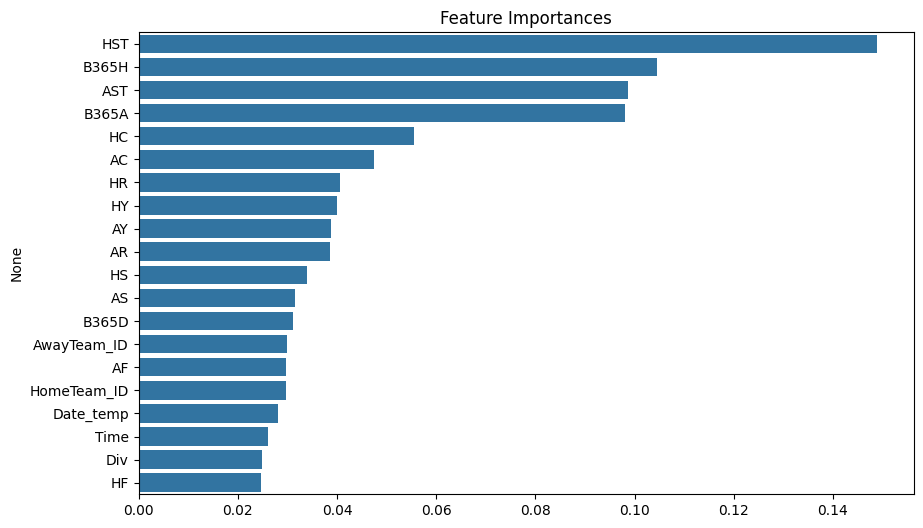

In [101]:
# Show the 20 most important features
importances = search.best_estimator_['xgb'].feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10, 6))
sns.barplot(x=importances[indices][:20], y=X_train.columns[indices][:20])
plt.title('Feature Importances')
plt.show()


### Validation

In [102]:
# Apply the model to the validation set
y_val = df_val['FTR']
X_val = df_val.drop('FTR', axis=1)
y_pred = search.predict(X_val)

# print the classification report
print(classification_report(y_val, y_pred))


              precision    recall  f1-score   support

           0       0.75      0.79      0.77       276
           1       0.72      0.67      0.69       224

    accuracy                           0.74       500
   macro avg       0.73      0.73      0.73       500
weighted avg       0.74      0.74      0.73       500

